<a href="https://colab.research.google.com/github/peterakinnawo/mental_health_chatbot/blob/main/Chatbot_for_Mental_Health_Conversations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'mental-health-conversational-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2594075%2F4429121%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240724%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240724T233109Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2cdc2c23e86979a79f87051068f2a3d06cf7d6ee7fc32c3824e7cfc57b827dd286626e862b96ca3b0f8dc2b78edfec28eee08e2d0d9b33947dcf979ac0ac1d5f47b4f347804d3bd87696718f8c7ab58a7a0749a6a88ad986a03ebbf0b81992a1a1bdebdfdcefecc2d7804de2594dde9e984a4db2a60c576bffcd1821bf1955369878278450cbc2b64d77629e089eafef3a0b65c498f75b6a11a5e7a5fac15b176a3ba1b7e327eb3cb571eab5d06eb3d9b0f44c66ce72292f6bdad384261cdc13fc1f9ba178e0c8ec812d5c6497c2d3029fd87b9b4494dfef0ceae71ed095e70ef952c260b9c1775a7188710c1f539fd42433df239483f2a4395676230a1b93dc'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 12068 bytes downloaded
Downloaded and uncompressed: mental-health-conversational-data
Data source import complete.


<!-- Codes by HTMLcodes.ws -->
<h1 style = "color:Blue;font-family:newtimeroman;font-size:250%;text-align:center;border-radius:15px 50px;">Chatbot for Mental Health Conversations</h1>


# Introduction

Building chatbots capable of providing emotional support to individuals experiencing anxiety and depression has become a key focus in the field of artificial intelligence. A crucial component in developing such chatbots is a well-structured dataset, which serves as the foundation for training models to comprehend and respond empathetically to user messages.

The dataset available here is a comprehensive collection of conversations related to mental health. It encompasses various conversation types, including basic exchanges, frequently asked questions about mental health, classical therapy discussions, and general advice given to individuals facing anxiety and depression. The primary objective of this dataset is to facilitate the training of a chatbot model that emulates a therapist, capable of providing empathetic and supportive responses to those seeking emotional solace.

To train the model effectively, the dataset incorporates the concept of "intents." Each intent represents the underlying purpose behind a user's message. For example, if a user expresses sadness, the associated intent would be "sad." Each intent is accompanied by a set of patterns, which are example messages aligning with the specific intent, as well as corresponding responses that the chatbot should generate based on that intent. Through defining multiple intents and their respective patterns and responses, the model learns to identify user intents and generate relevant and compassionate replies.

By utilizing this dataset, researchers and developers can train chatbot models to better understand and support individuals coping with anxiety and depression. The goal is to create a virtual conversational agent that can offer emotional guidance, provide helpful insights, and alleviate some of the challenges faced by those seeking mental health support.

# Data Preparation

* Load the dataset into a suitable data structure (e.g., Pandas DataFrame).
* Examine the dataset to understand its structure and distribution.
* Preprocess the data by removing unnecessary characters, converting text to lowercase, and handling any missing values.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mental-health-conversational-data/intents.json


In [3]:
import json

with open('/kaggle/input/mental-health-conversational-data/intents.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data['intents'])
df

,tag,patterns,responses
0,greeting,"[Hi, Hey, Is anyone there?, Hi there, Hello, H...",[Hello there. Tell me how are you feeling toda...
1,morning,[Good morning],[Good morning. I hope you had a good night's s...
2,afternoon,[Good afternoon],[Good afternoon. How is your day going?]
3,evening,[Good evening],[Good evening. How has your day been?]
4,night,[Good night],"[Good night. Get some proper sleep, Good night..."
...,...,...,...
75,fact-28,[What do I do if I'm worried about my mental h...,[The most important thing is to talk to someon...
76,fact-29,[How do I know if I'm unwell?],"[If your beliefs , thoughts , feelings or beha..."
77,fact-30,[How can I maintain social connections? What i...,"[A lot of people are alone right now, but we d..."
78,fact-31,[What's the difference between anxiety and str...,[Stress and anxiety are often used interchange...


In [4]:
dic = {"tag":[], "patterns":[], "responses":[]}
for i in range(len(df)):
    ptrns = df[df.index == i]['patterns'].values[0]
    rspns = df[df.index == i]['responses'].values[0]
    tag = df[df.index == i]['tag'].values[0]
    for j in range(len(ptrns)):
        dic['tag'].append(tag)
        dic['patterns'].append(ptrns[j])
        dic['responses'].append(rspns)

df = pd.DataFrame.from_dict(dic)
df

,tag,patterns,responses
0,greeting,Hi,[Hello there. Tell me how are you feeling toda...
1,greeting,Hey,[Hello there. Tell me how are you feeling toda...
2,greeting,Is anyone there?,[Hello there. Tell me how are you feeling toda...
3,greeting,Hi there,[Hello there. Tell me how are you feeling toda...
4,greeting,Hello,[Hello there. Tell me how are you feeling toda...
...,...,...,...
227,fact-29,How do I know if I'm unwell?,"[If your beliefs , thoughts , feelings or beha..."
228,fact-30,How can I maintain social connections? What if...,"[A lot of people are alone right now, but we d..."
229,fact-31,What's the difference between anxiety and stress?,[Stress and anxiety are often used interchange...
230,fact-32,What's the difference between sadness and depr...,"[Sadness is a normal reaction to a loss, disap..."


In [5]:
df['tag'].unique()

array(['greeting', 'morning', 'afternoon', 'evening', 'night', 'goodbye',
       'thanks', 'no-response', 'neutral-response', 'about', 'skill',
       'creation', 'name', 'help', 'sad', 'stressed', 'worthless',
       'depressed', 'happy', 'casual', 'anxious', 'not-talking', 'sleep',
       'scared', 'death', 'understand', 'done', 'suicide', 'hate-you',
       'hate-me', 'default', 'jokes', 'repeat', 'wrong', 'stupid',
       'location', 'something-else', 'friends', 'ask', 'problem',
       'no-approach', 'learn-more', 'user-agree', 'meditation',
       'user-meditation', 'pandora-useful', 'user-advice',
       'learn-mental-health', 'mental-health-fact', 'fact-1', 'fact-2',
       'fact-3', 'fact-5', 'fact-6', 'fact-7', 'fact-8', 'fact-9',
       'fact-10', 'fact-11', 'fact-12', 'fact-13', 'fact-14', 'fact-15',
       'fact-16', 'fact-17', 'fact-18', 'fact-19', 'fact-20', 'fact-21',
       'fact-22', 'fact-23', 'fact-24', 'fact-25', 'fact-26', 'fact-27',
       'fact-28', 'fact-29', '

# Exploratory Data Analysis

* Analyze the distribution of intents in the dataset.
* Visualize the frequency of different intents using a bar plot from the Plotly library. The x-axis can represent the intents, and the y-axis can represent the count of patterns or responses associated with each intent.



In [6]:
import plotly.graph_objects as go

intent_counts = df['tag'].value_counts()
fig = go.Figure(data=[go.Bar(x=intent_counts.index, y=intent_counts.values)])
fig.update_layout(title='Distribution of Intents', xaxis_title='Intents', yaxis_title='Count')
fig.show()

# Pattern and Response Analysis

* Explore the patterns and responses associated with each intent.
* Calculate the average number of patterns and responses per intent.
* Visualize this information using a Plotly bar plot, where the x-axis represents the intents, and the y-axis represents the average count of patterns or responses.
* Interpret the plot to understand the varying degrees of complexity and diversity in patterns and responses across different intents.

In [7]:
df['pattern_count'] = df['patterns'].apply(lambda x: len(x))
df['response_count'] = df['responses'].apply(lambda x: len(x))
avg_pattern_count = df.groupby('tag')['pattern_count'].mean()
avg_response_count = df.groupby('tag')['response_count'].mean()

fig = go.Figure()
fig.add_trace(go.Bar(x=avg_pattern_count.index, y=avg_pattern_count.values, name='Average Pattern Count'))
fig.add_trace(go.Bar(x=avg_response_count.index, y=avg_response_count.values, name='Average Response Count'))
fig.update_layout(title='Pattern and Response Analysis', xaxis_title='Intents', yaxis_title='Average Count')
fig.show()

# Intent Prediction Model

* Split the dataset into training and testing sets.
* Implement a machine learning or deep learning model suitable for intent prediction, such as a text classification model.
* Vectorize the text data (e.g., using TF-IDF or word embeddings) and train the model using the patterns as input and the corresponding intents as target variables.
* Evaluate the model's performance on the testing set using appropriate metrics like accuracy, precision, recall, and F1-score.
* Visualize the model's performance using a Plotly bar plot, where the x-axis represents the evaluation metrics, and the y-axis represents the corresponding scores.
* Interpret the plot to analyze the effectiveness of the intent prediction model.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import plotly.graph_objects as go

In [9]:
# Split the dataset into training and testing sets
X = df['patterns']
y = df['tag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train a Support Vector Machine (SVM) classifier
model = SVC()
model.fit(X_train_vec, y_train)

# Predict intents for the testing set
y_pred = model.predict(X_test_vec)

# Evaluate the model's performance
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

# Convert float values in the report to dictionaries
report = {label: {metric: report[label][metric] for metric in report[label]} for label in report if isinstance(report[label], dict)}

# Extract evaluation metrics
labels = list(report.keys())
evaluation_metrics = ['precision', 'recall', 'f1-score']
metric_scores = {metric: [report[label][metric] for label in labels if label in report] for metric in evaluation_metrics}

# Visualize the model's performance using a Plotly bar plot
fig = go.Figure()
for metric in evaluation_metrics:
    fig.add_trace(go.Bar(name=metric, x=labels, y=metric_scores[metric]))

fig.update_layout(title='Intent Prediction Model Performance',
                  xaxis_title='Intent',
                  yaxis_title='Score',
                  barmode='group')

fig.show()


# Prediction Model Deployment

* Once satisfied with the model's performance, deploy the intent prediction model in a chatbot framework.
* Utilize the trained model to predict intents based on user input in real-time.
* Implement an appropriate response generation mechanism to provide relevant and empathetic responses based on the predicted intents.

In [10]:
# Prediction Model Deployment

# A trained SVM model named 'model' and a vectorizer named 'vectorizer'

# Function to predict intents based on user input
def predict_intent(user_input):
    # Vectorize the user input
    user_input_vec = vectorizer.transform([user_input])

    # Predict the intent
    intent = model.predict(user_input_vec)[0]

    return intent

# Function to generate responses based on predicted intents
def generate_response(intent):
    # Implement your logic here to generate appropriate responses based on the predicted intents
    if intent == 'greeting':
        response = "Hello! How can I assist you today?"
    elif intent == 'farewell':
        response = "Goodbye! Take care."
    elif intent == 'question':
        response = "I'm sorry, I don't have the information you're looking for."
    else:
        response = "I'm here to help. Please let me know how I can assist you."

    return response

# Example usage
while True:
    # Get user input
    user_input = input("User: ")

    # Predict intent
    intent = predict_intent(user_input)

    # Generate response
    response = generate_response(intent)

    print("Chatbot:", response)


User: Hi
Chatbot: Hello! How can I assist you today?
User: I am feeling tired
Chatbot: I'm here to help. Please let me know how I can assist you.
User: I am feeling depressed
Chatbot: I'm here to help. Please let me know how I can assist you.
User: I don't know what else to do
Chatbot: Hello! How can I assist you today?
User: I feel like i am dead
Chatbot: I'm here to help. Please let me know how I can assist you.
User: Bye
Chatbot: I'm here to help. Please let me know how I can assist you.


KeyboardInterrupt: Interrupted by user

# Conclusion

In conclusion, the availability of a well-structured dataset encompassing various conversations related to mental health provides a valuable resource for training chatbot models to offer emotional support to individuals dealing with anxiety and depression. By utilizing intents, patterns, and responses, the models can learn to understand user messages and generate empathetic and relevant replies.

The use of such models in chatbot frameworks holds great potential for providing accessible and compassionate support to those in need of mental health assistance. By simulating the behavior of a therapist, these chatbots can offer guidance, answer frequently asked questions, and provide general advice to individuals experiencing anxiety and depression.

By leveraging the insights and knowledge gained from this dataset, researchers and developers can contribute to the development of chatbots that serve as virtual companions, offering emotional solace and alleviating some of the burdens faced by individuals seeking mental health support.

Overall, the dataset and the subsequent training of chatbot models enable the creation of innovative tools that bridge the gap in mental health care, providing individuals with a readily available resource for emotional support and guidance.

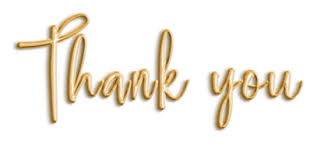

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
Your upvote is a great way to show your support and help others discover this valuable resource.
Please share your comments and suggestions

<div class="alert alert-block alert-info"> 📌 Note: If you fork my notebook, please don't forget to upvote it. </div>
